In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataset(csv_file):
  # Load the CSV file
  data = pd.read_csv(csv_file)

  # Split data into 70% train and 30% remaining
  train_data, remaining_data = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)

  # Split remaining data into 50% validation and 50% test (15% of the original each)
  validation_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42, shuffle=True)

  # Output the split datasets
  print("Training Data:", len(train_data))
  print("Validation Data:", len(validation_data))
  print("Testing Data:", len(test_data))

  return train_data, validation_data, test_data

train_data, validation_data, test_data = split_dataset('/content/drive/My Drive/AI4C/HW3/metadata.csv')

Training Data: 3498
Validation Data: 750
Testing Data: 750


In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # Get giraffe and zebra labels directly from the dataframe
        giraffe_label = self.dataframe.iloc[idx, 1]
        zebra_label = self.dataframe.iloc[idx, 2]

        label = torch.tensor([giraffe_label, zebra_label])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
])

train_dataset = MyDataset(dataframe=train_data, image_dir='/content/drive/My Drive/AI4C/HW3/images', transform=transform)
validation_dataset = MyDataset(dataframe=validation_data, image_dir='/content/drive/My Drive/AI4C/HW3/images', transform=transform)
test_dataset = MyDataset(dataframe=test_data, image_dir='/content/drive/My Drive/AI4C/HW3/images', transform=transform)


class_counts = torch.tensor([35, 3094, 363, 6], dtype=torch.float32)

class_weights = 1.0 / class_counts
sample_weights = []

for image, label in train_dataset:
    class_idx = label[0].item() * 2 + label[1].item()
    sample_weights.append(class_weights[class_idx])

sample_weights = torch.tensor(sample_weights)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, sampler=sampler)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
import matplotlib.pyplot as plt
import random
from collections import Counter

def test_datasets(train_dataset, validation_dataset, test_dataset, image_dir):
    train_ids = [train_dataset.dataframe.iloc[i, 0] for i in range(len(train_dataset))]
    val_ids = [validation_dataset.dataframe.iloc[i, 0] for i in range(len(validation_dataset))]
    test_ids = [test_dataset.dataframe.iloc[i, 0] for i in range(len(test_dataset))]

    # Convert lists to sets for disjoint check
    train_set = set(train_ids)
    val_set = set(val_ids)
    test_set = set(test_ids)

    # Check for disjoint sets
    print("Train-Validation Disjoint:", train_set.isdisjoint(val_set))
    print("Train-Test Disjoint:", train_set.isdisjoint(test_set))
    print("Validation-Test Disjoint:", val_set.isdisjoint(test_set))

    # Collect all filenames in the directory
    all_files = set(os.listdir(image_dir))
    combined_sets = train_set.union(val_set).union(test_set)

    # Verify all images are included
    print("All images accounted for:", all_files == combined_sets)

test_datasets(train_dataset, validation_dataset, test_dataset, '/content/drive/My Drive/AI4C/HW3/images')

Train-Validation Disjoint: True
Train-Test Disjoint: True
Validation-Test Disjoint: True
All images accounted for: True


Training - Giraffe Images: 363
Training - Zebra Images: 3094
Training - Neither Images: 35
Training - Both Images: 6


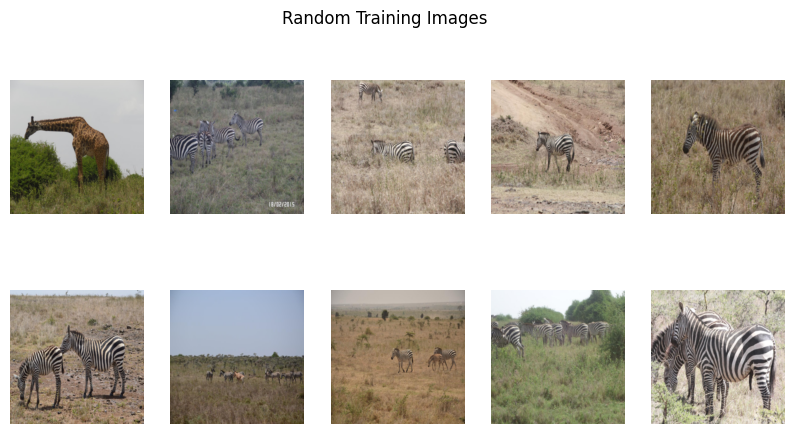

Validation - Giraffe Images: 81
Validation - Zebra Images: 660
Validation - Neither Images: 9
Validation - Both Images: 0


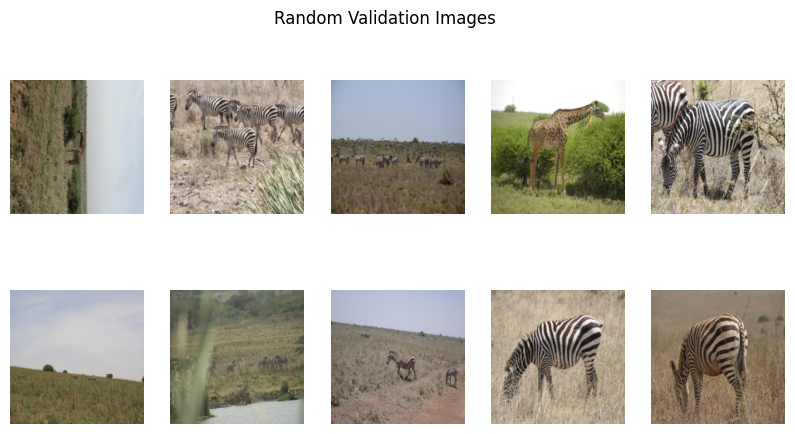

Testing - Giraffe Images: 99
Testing - Zebra Images: 644
Testing - Neither Images: 6
Testing - Both Images: 1


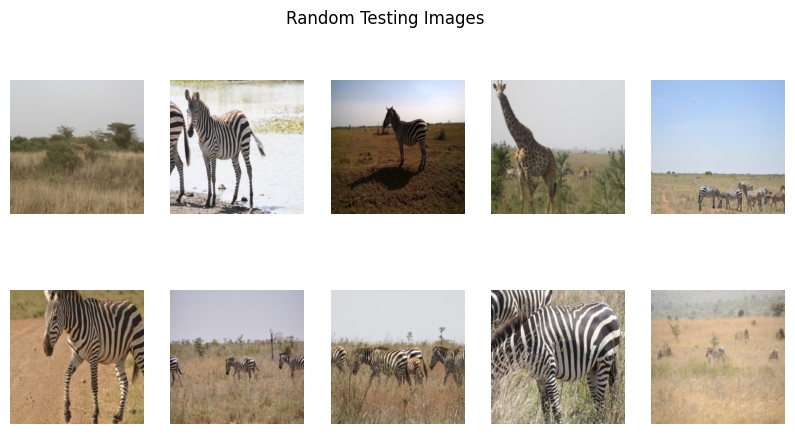

In [29]:
import matplotlib.pyplot as plt
from collections import Counter

def explore_datasets(dataset, dataset_name):

  both_count = 0
  giraffe_count = 0
  zebra_count = 0
  neither_count = 0

  for i in range(len(dataset)):

    label = dataset[i][1]

    # Check label conditions using tensor equality
    if torch.equal(label, torch.tensor([1, 1])):
        both_count += 1
    elif torch.equal(label, torch.tensor([1, 0])):
        giraffe_count += 1
    elif torch.equal(label, torch.tensor([0, 1])):
        zebra_count += 1
    elif torch.equal(label, torch.tensor([0, 0])):
        neither_count += 1


  print(f"{dataset_name} - Giraffe Images: {giraffe_count}")
  print(f"{dataset_name} - Zebra Images: {zebra_count}")
  print(f"{dataset_name} - Neither Images: {neither_count}")
  print(f"{dataset_name} - Both Images: {both_count}")

  # Display random images from the dataset
  def display_random_images(dataset, title):
      plt.figure(figsize=(10, 5))
      plt.suptitle(title)
      for i in range(1, 11):  # Display 10 images
          ax = plt.subplot(2, 5, i)
          idx = random.randint(0, len(dataset) - 1)
          image, _ = dataset[idx]
          plt.imshow(image.permute(1, 2, 0))
          plt.axis('off')
      plt.show()

  display_random_images(dataset, f'Random {dataset_name} Images')

explore_datasets(train_dataset, 'Training')
explore_datasets(validation_dataset, 'Validation')
explore_datasets(test_dataset, 'Testing')

In [30]:
torch.manual_seed(42)  # Set the seed for all CPU-generated random numbers

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # Set the seed for all GPU-generated random numbers
    device = "cuda"
else:
    device = "cpu"

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)
weights = torch.tensor([1, 10]).float().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = weights)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [31]:
def train(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.train()
  total_loss, total_accuracy = 0, 0

  for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device).float()

    optimizer.zero_grad()
    pred = model(images)

    loss = loss_fn(pred, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    preds = (torch.sigmoid(pred) > 0.5).float()
    total_accuracy += (preds == labels).float().mean().item()

  avg_loss = total_loss / len(dataloader)
  avg_accuracy = 100 * total_accuracy / len(dataloader)
  print(f"Training - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

def test(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, total_accuracy = 0, 0

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device).float()

      preds = model(images)
      loss = loss_fn(preds, labels)
      test_loss += loss.item()
      preds = (torch.sigmoid(preds) > 0.5).float()
      total_accuracy += (preds == labels).float().mean().item()

  avg_loss = test_loss / num_batches
  avg_accuracy = 100 * total_accuracy / num_batches
  print(f"Testing - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")
  return avg_accuracy

best_accuracy = 0.0
best_model_state_dict = None

epochs = 5
for epoch in range(epochs):
  train(train_loader, model, loss_fn, optimizer, device)
  accuracy = test(test_loader, model, loss_fn, optimizer, device)
  # Check if the current model is better
  if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model_state = model.state_dict()
      print(f"\nNew best model found with accuracy: {best_accuracy:.2f}%\n")
      torch.save(best_model_state, 'best_model.pth')  # Save best model

  if epoch == epochs - 1:
    print(f"\nAccuracy Score: {best_accuracy:.2f}")
print('\nDone!\n')

Training - Avg Loss: 0.3219, Avg Accuracy: 93.0653
Testing - Avg Loss: 0.1145, Avg Accuracy: 98.4375

New best model found with accuracy: 98.44%

Training - Avg Loss: 0.0748, Avg Accuracy: 99.3182
Testing - Avg Loss: 0.0757, Avg Accuracy: 99.0885

New best model found with accuracy: 99.09%

Training - Avg Loss: 0.0278, Avg Accuracy: 99.8011
Testing - Avg Loss: 0.0459, Avg Accuracy: 99.4792

New best model found with accuracy: 99.48%

Training - Avg Loss: 0.0424, Avg Accuracy: 99.6307
Testing - Avg Loss: 0.0352, Avg Accuracy: 99.6094

New best model found with accuracy: 99.61%

Training - Avg Loss: 0.0179, Avg Accuracy: 99.8722
Testing - Avg Loss: 0.0248, Avg Accuracy: 99.5443

Accuracy Score: 99.61

Done!



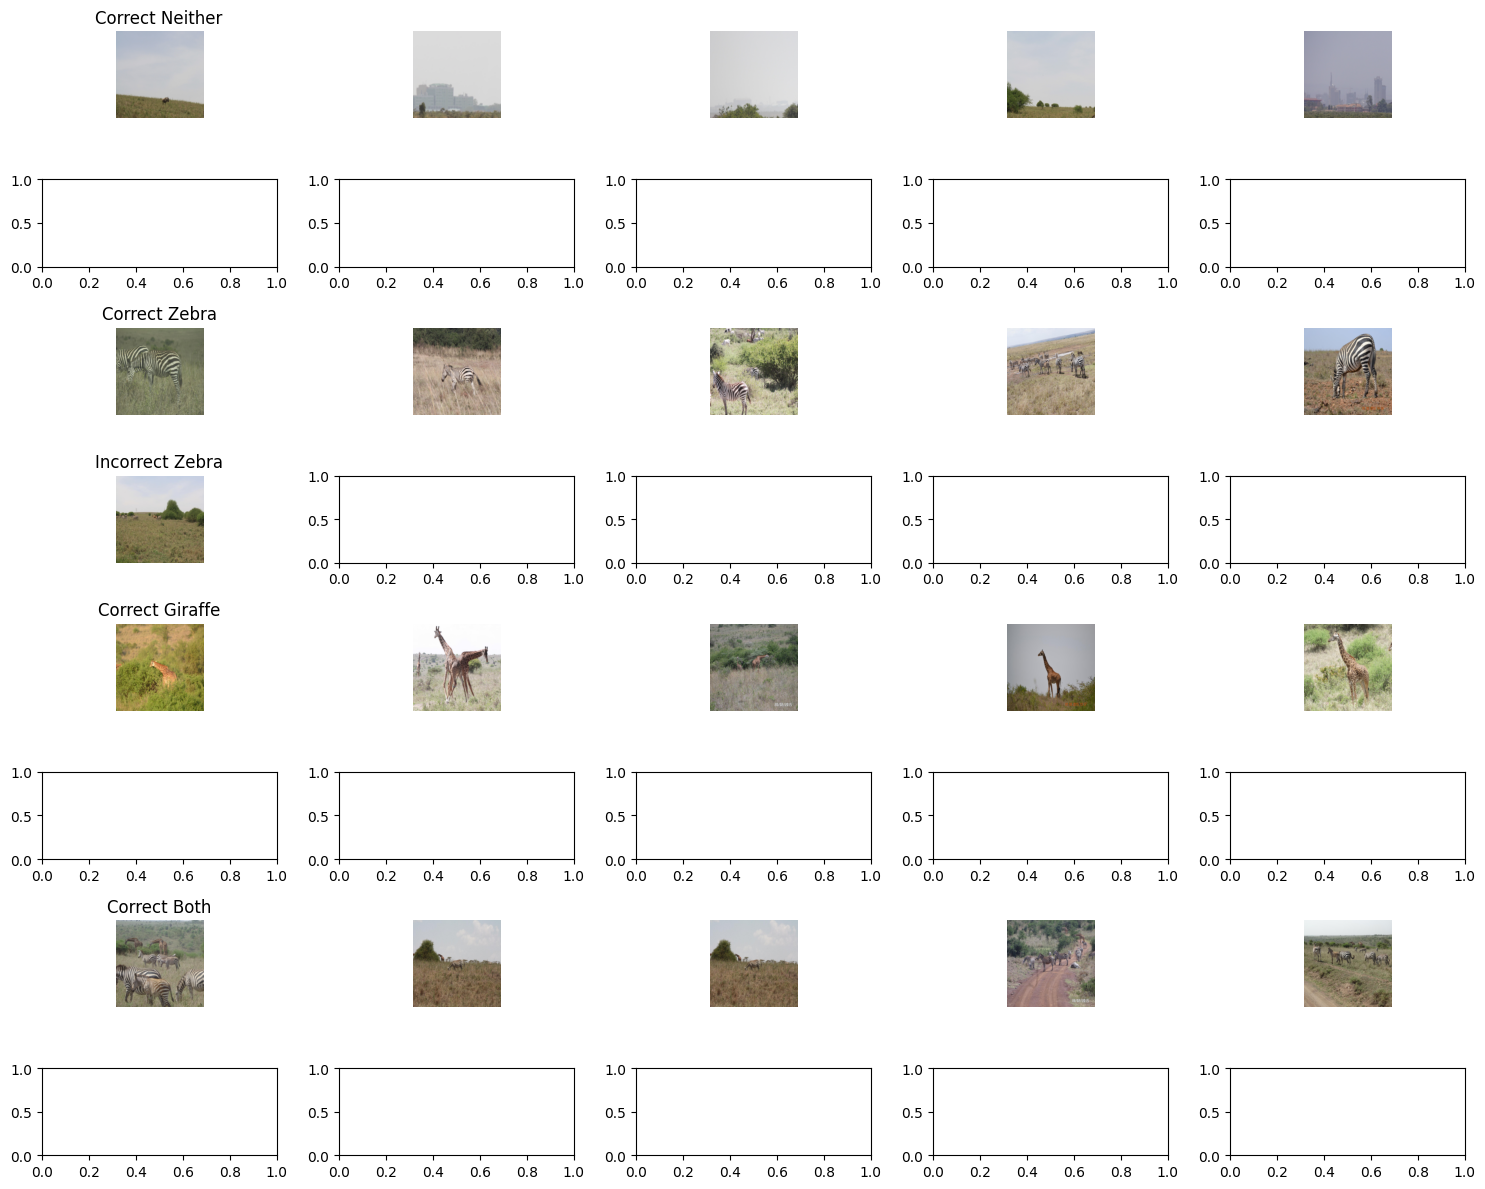

In [32]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def classify_and_collect_images(model, dataloader, device):
    model.eval()
    classified_images = {'correct': {0: [], 1: [], 2: [], 3: []}, 'incorrect': {0: [], 1: [], 2: [], 3: []}}

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            for img, pred, label in zip(images, preds, labels):
                img_class = torch.where(label == 1)[0].tolist()
                pred_class = torch.where(pred == 1)[0].tolist()

                # Determine class index for storage: 0 = neither, 1 = zebra, 2 = giraffe, 3 = both
                class_index = 0 if len(img_class) == 0 else (3 if len(img_class) > 1 else (1 if 1 in img_class else 2))

                if pred_class == img_class:
                    classified_images['correct'][class_index].append((img.cpu(), class_index))
                else:
                    classified_images['incorrect'][class_index].append((img.cpu(), class_index))

                # Limit to 5 images per category
                for key in classified_images:
                    for class_key in classified_images[key]:
                        if len(classified_images[key][class_key]) > 5:
                            classified_images[key][class_key] = classified_images[key][class_key][:5]

    return classified_images

def display_classified_images(classified_images):
    fig, axs = plt.subplots(8, 5, figsize=(15, 12))
    axs = axs.ravel()

    for i, key in enumerate(['correct', 'incorrect']):
        for j, class_type in enumerate(['Neither', 'Zebra', 'Giraffe', 'Both']):
            images = classified_images[key][j]
            for k, (img, _) in enumerate(images):
                ax = axs[2 * 5 * j + 5 * i + k]
                ax.imshow(img.permute(1, 2, 0))
                ax.axis('off')
                if k == 0:
                    ax.set_title(f"{key.capitalize()} {class_type}")

    plt.tight_layout()
    plt.show()

classified_images = classify_and_collect_images(model, train_loader, device)
display_classified_images(classified_images)

In [34]:
!pip install ultralytics

In [51]:
from ultralytics import YOLO

model = YOLO("yolov10n.pt")

# Example usage with your image filenames
image_filenames = ['/content/drive/My Drive/AI4C/HW3/images/000000000561.jpg',
                   '/content/drive/My Drive/AI4C/HW3/images/000000004713.jpg',
                   '/content/drive/My Drive/AI4C/HW3/images/000000003599.jpg',
                   '/content/drive/My Drive/AI4C/HW3/images/000000000521.jpg']

for image_path in image_filenames:
    results = model(image_path)
    results[0].show()


Output hidden; open in https://colab.research.google.com to view.

The results are incomplete and highlight the need for improvement, particularly in more comprehensive animal detection across all frames.

1. **Missing Bounding Boxes**: In two of the four images, there are clearly animals (both zebras and giraffes) that are not detected at all. This is a significant issue since complete animals are in view but are ignored by the model.

2. **Uneven Performance**: The model performs well in detecting zebras but struggles more with giraffes, especially in crowded or more complex scenes. This might indicate insufficient training on certain configurations or species.

3. **No Mislabeled or Duplicate Boxes**: No animals have been mislabeled, and there are no duplicate bounding boxes. However, the primary issue is the absence of boxes where detections should have occurred.